<a href="https://colab.research.google.com/github/PetrBonyuk/m_o/blob/main/vietnam_housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Рассматривается задача прогнозирования цен на жилье во Вьетнаме на основе набора данных, содержащего различные характеристики объектов недвижимости. Целью является разработка модели, которая сможет предсказывать цены на жилье с высокой точностью. Для достижения этой цели будут выполнены следующие шаги:

**Прочитать данные:** Загрузка и предварительный анализ данных для понимания их структуры и содержания.

**Визуализировать данные и вычислить основные характеристики:** Построение графиков и вычисление статистических показателей для анализа распределения данных и выявления взаимосвязей между признаками.

**Обработать пропущенные значения:** Проверка наличия пропущенных значений и их обработка, если они присутствуют.

**Обработать категориальные признаки:** Преобразование категориальных признаков в числовые для использования в модели.

**Провести нормализацию:** Определение необходимости нормализации данных и ее проведение, если это необходимо.

**Разбить данные на обучающую и тестовую выборки:** Разделение данных на обучающую и тестовую выборки для оценки качества модели.

**Запустить классификатор (регрессию) ближайших соседей:** Выбор и обучение модели ближайших соседей для прогнозирования цен на жилье.

**Вычислить ошибки на обучающей и тестовой выборках:** Оценка качества модели на обучающей и тестовой выборках и выбор оптимального значения гиперпараметра.

**Запустить другие классификаторы:** По желанию, обучение и сравнение результатов других моделей.

**Побороться с несбалансированностью классов:** По желанию, обработка несбалансированности классов, если она присутствует.

**Исключить коррелированные переменные:** По желанию, исключение коррелированных признаков для улучшения качества модели.

**Сделать общие выводы:** Подведение итогов и выводы по результатам работы.

**Процесс решения**
В процессе решения задачи будут использованы различные методы и инструменты для анализа данных и построения модели. На первом этапе будет проведен предварительный анализ данных с использованием визуализации и статистических методов. Затем будет выполнена обработка пропущенных значений и преобразование категориальных признаков. После этого данные будут разделены на обучающую и тестовую выборки, и будет построена модель ближайших соседей для прогнозирования цен на жилье. На заключительном этапе будут сделаны выводы по результатам работы и предложены возможные пути улучшения модели.

In [ ]:
# @title Загрузка библиотек
!pip install pandas
!pip install xlrd
!pip install category_encoders
!pip install --upgrade scikit-learn
!pip install catboost

In [ ]:
# @title Загрузка Data Set
from google.colab import files

uploaded = files.upload()

In [143]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import  StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score,RandomizedSearchCV
from category_encoders import TargetEncoder, CountEncoder
from tabulate import tabulate
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.compose import ColumnTransformer
import optuna
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import catboost as cb
from catboost import CatBoostRegressor

In [194]:
# @title Чтение .xlsx файла

df = pd.read_excel('vietnam_housing_dataset.xlsx', engine='openpyxl')

In [197]:
df_dropna=df.dropna()
#@title Выбор числовых признаков
numeric_features = df_dropna.iloc[:, [1, 2, 3, 6, 7, 8, 11]]

In [165]:
#@title Вычисление среднего значения, дисперсии и стандартного отклонения
mean_values = numeric_features.mean()
variance_values = numeric_features.var()
std_values = numeric_features.std()

# Создание DataFrame для отображения результатов
summary_df = pd.DataFrame({
    'Среднее': mean_values,
    'Дисперсия': variance_values,
    'Стандартное отклонение': std_values
})

# Вывод результатов
print(summary_df)


               Среднее    Дисперсия  Стандартное отклонение
Area         70.722979  2536.062883               50.359338
Frontage      5.480749    24.183416                4.917664
Access Road   7.605142    57.323186                7.571208
Floors        3.209452     1.633118                1.277935
Bedrooms      3.473346     1.398400                1.182540
Bathrooms     3.355009     1.798656                1.341140
Price         5.444760     5.022046                2.240992


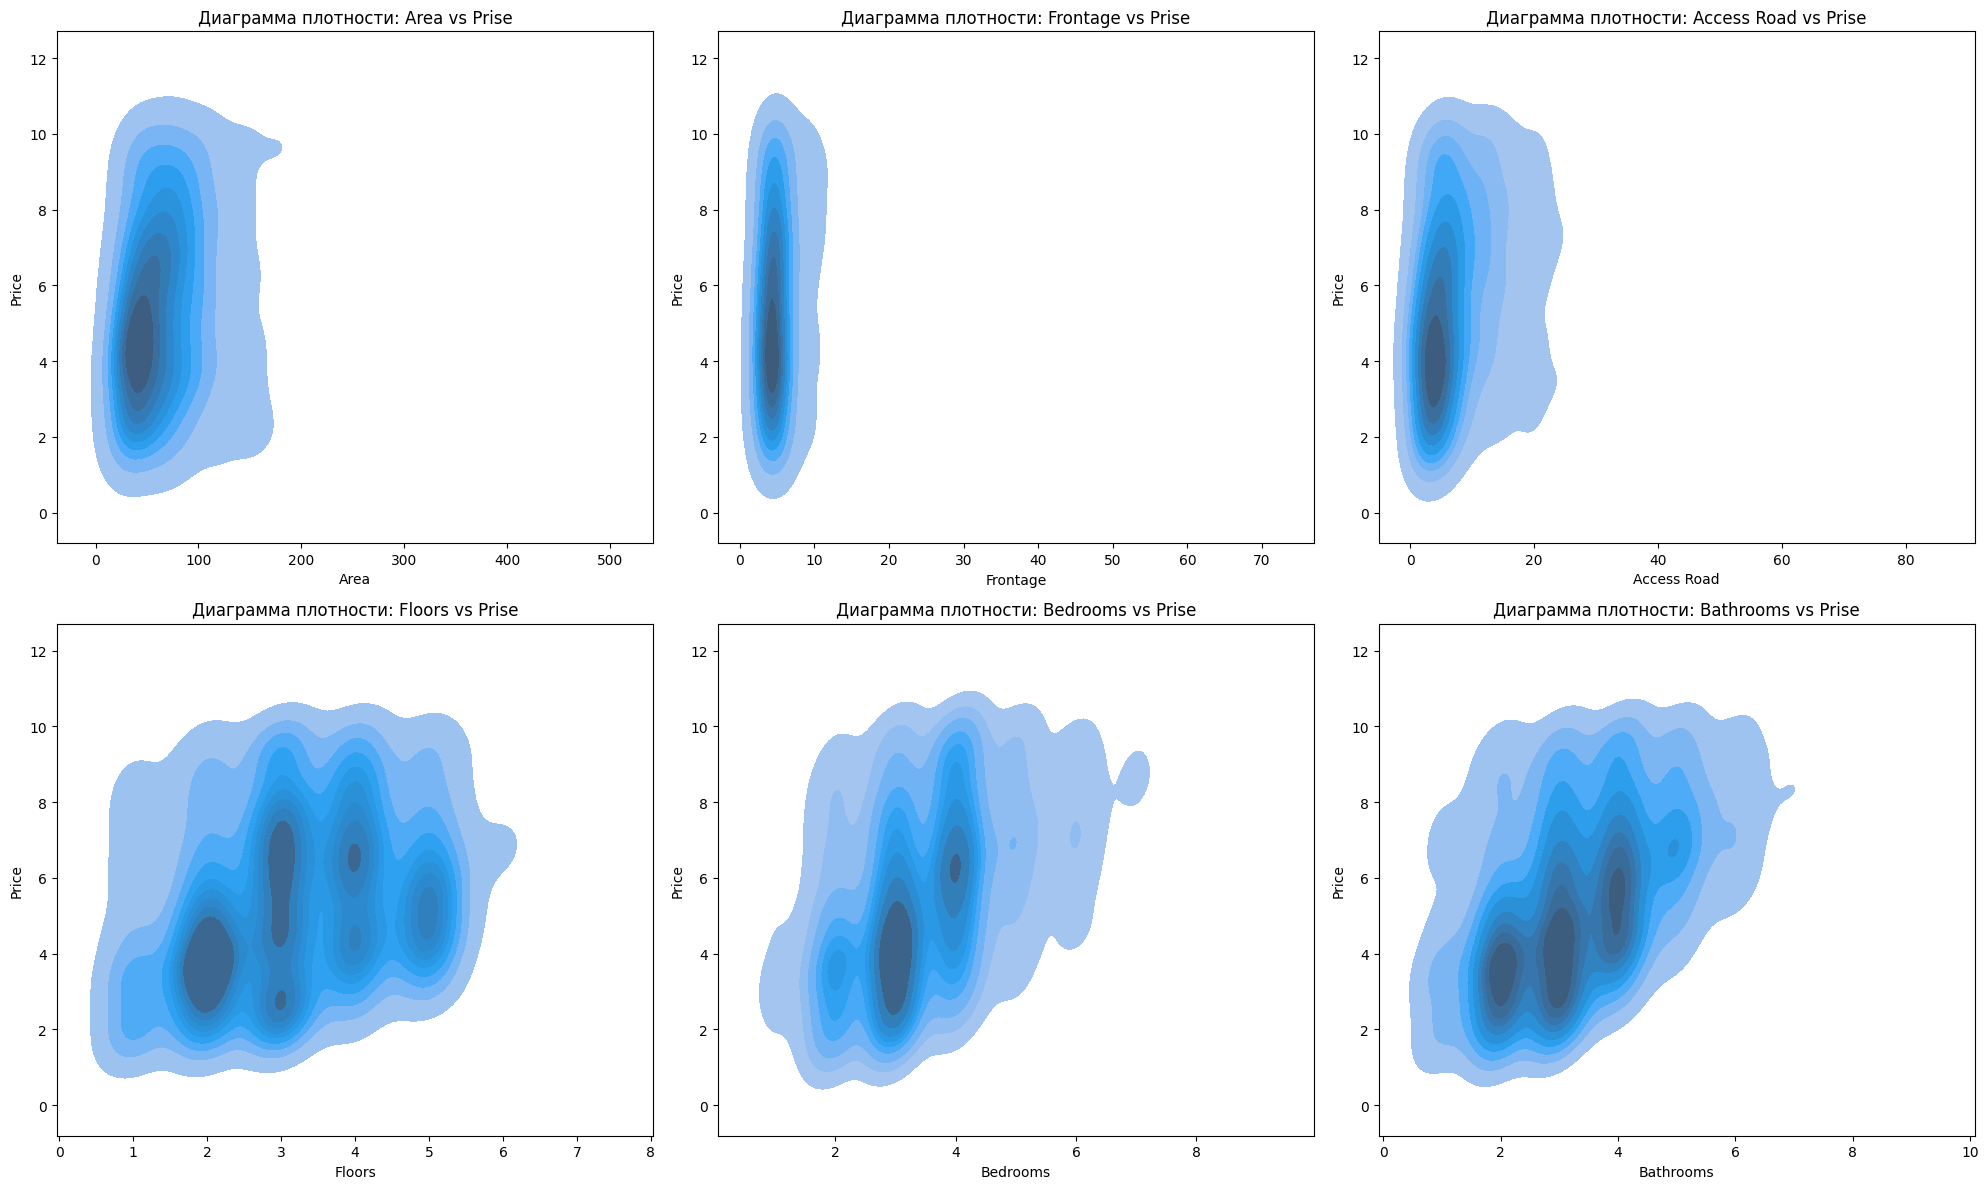

In [162]:
# @title Визуализация данных
numeric_features1 = ['Area', 'Frontage', 'Access Road', 'Floors', 'Bedrooms', 'Bathrooms']

# Создание подграфиков
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

# Построение KDE для каждого числового признака
for i, feature in enumerate(numeric_features1):
    sns.kdeplot(x=feature, y='Price', data=df_dropna, fill=True, ax=axes[i])
    axes[i].set_title(f'Диаграмма плотности: {feature} vs Prise')

# Отображение графиков
plt.tight_layout()
plt.show()

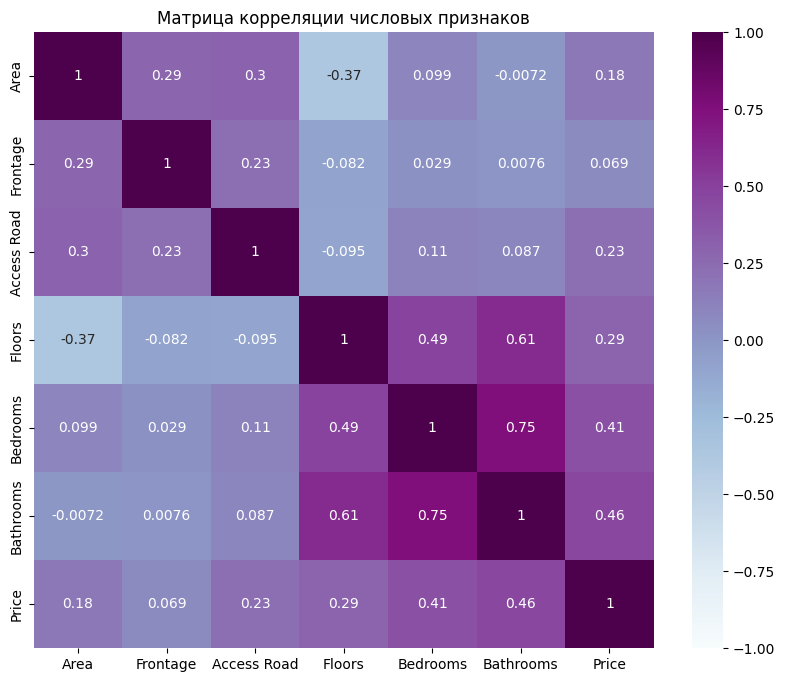

In [170]:
#@title Матрица корреляции
# Стандартизация данных
scaler = StandardScaler()
numeric_features_scaled = scaler.fit_transform(numeric_features)

# Преобразование обратно в DataFrame для удобства
numeric_features_scaled_df = pd.DataFrame(numeric_features_scaled, columns=numeric_features.columns)

# Вычисление матрицы корреляции
correlation_matrix = numeric_features_scaled_df.corr()

# Построение тепловой карты корреляции
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='BuPu',vmin = -1, vmax = 1)
plt.title('Матрица корреляции числовых признаков')
plt.show()


<ipython-input-200-7b1c5ca61fb7>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby('Legal status', group_keys=False).apply(lambda x: x.sample(min_count, random_state=42)).reset_index(drop=True)


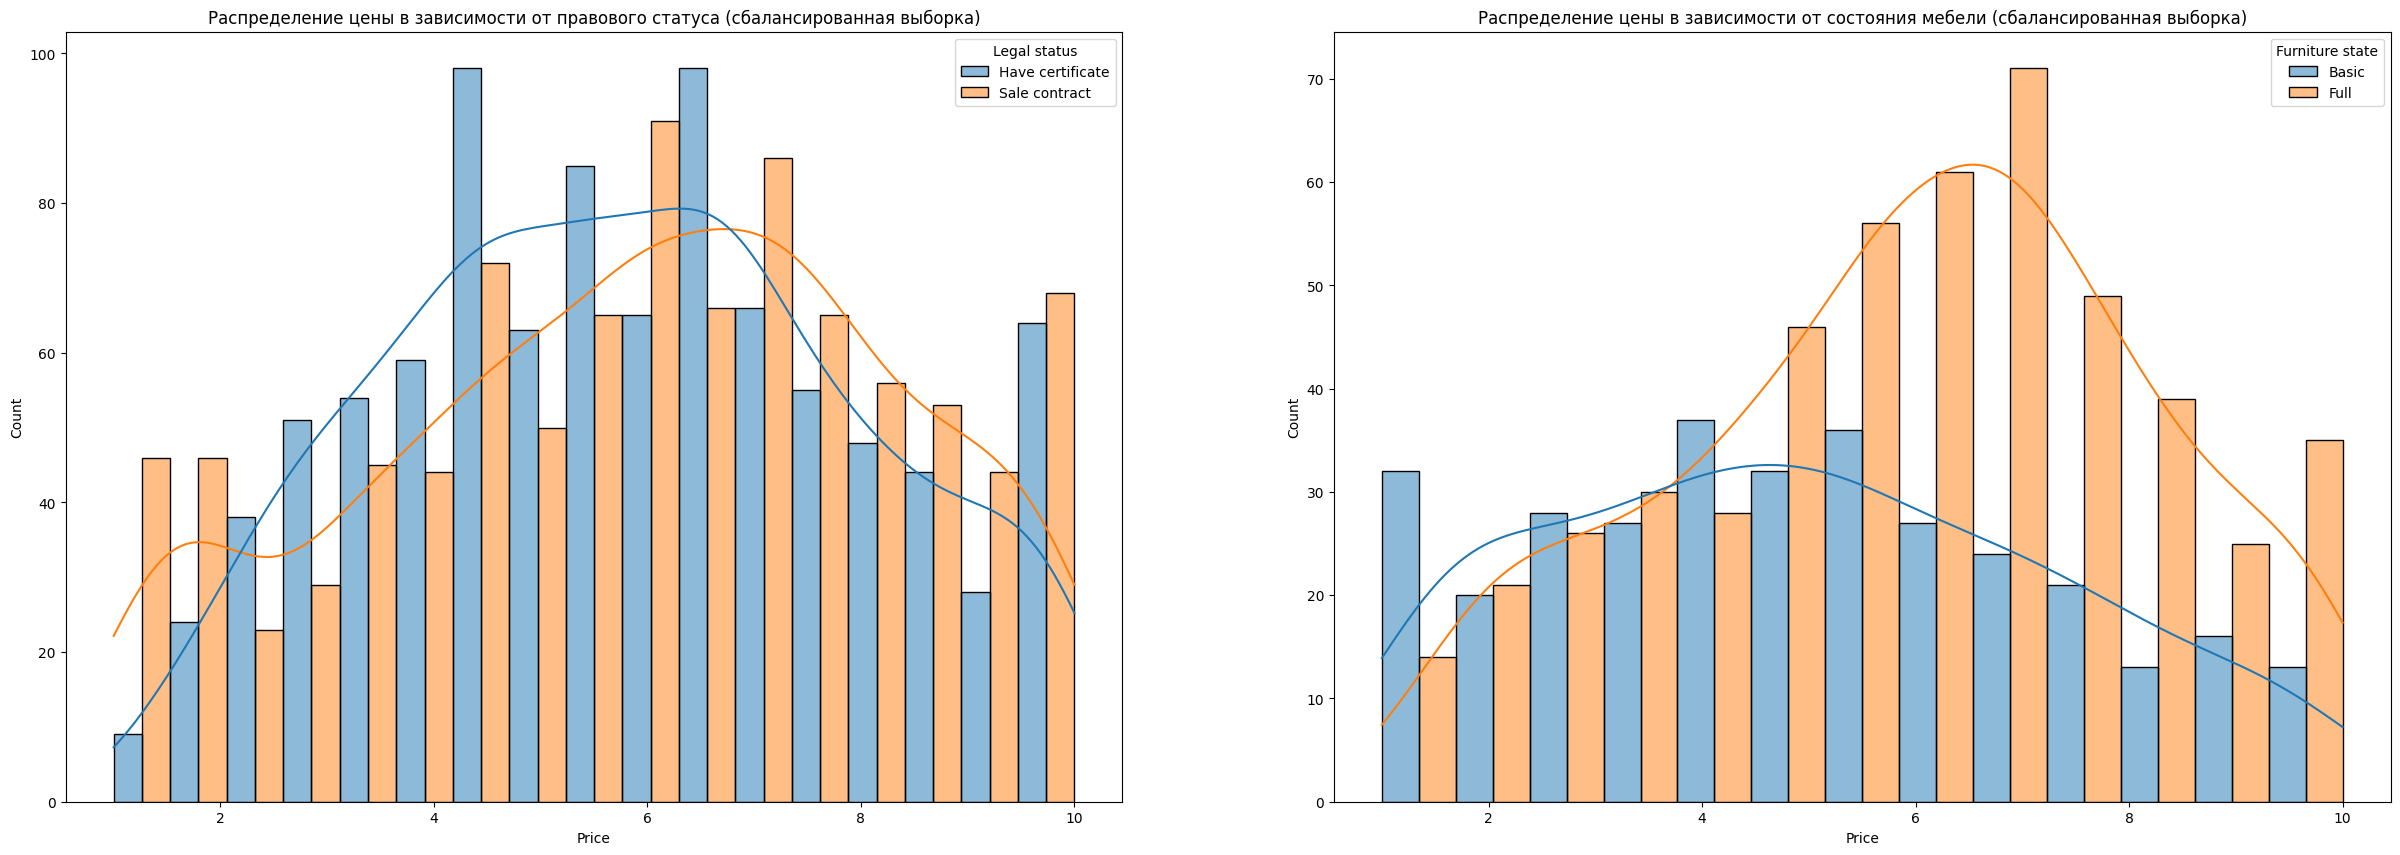

In [200]:
# Балансировка данных по признаку Legal status
min_count = df['Legal status'].value_counts().min()
sampled_df = df.groupby('Legal status', group_keys=False).apply(lambda x: x.sample(min_count, random_state=42)).reset_index(drop=True)

# Создание двух графиков рядом
fig, axes = plt.subplots(1, 2, figsize=(30, 10))

# Гистограмма для правового статуса
sns.histplot(data=sampled_df, x='Price', hue='Legal status', kde=True, multiple='dodge', ax=axes[0])
axes[0].set_title('Распределение цены в зависимости от правового статуса (сбалансированная выборка)')

# Гистограмма для состояния мебели
sns.histplot(data=sampled_df, x='Price', hue='Furniture state', kde=True, multiple='dodge', ax=axes[1])
axes[1].set_title('Распределение цены в зависимости от состояния мебели (сбалансированная выборка)')

# Отображение графиков
plt.show()

<ipython-input-201-7b3d7d4ddd3a>:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby('House direction', group_keys=False).apply(lambda x: x.sample(min_count, random_state=42)).reset_index(drop=True)


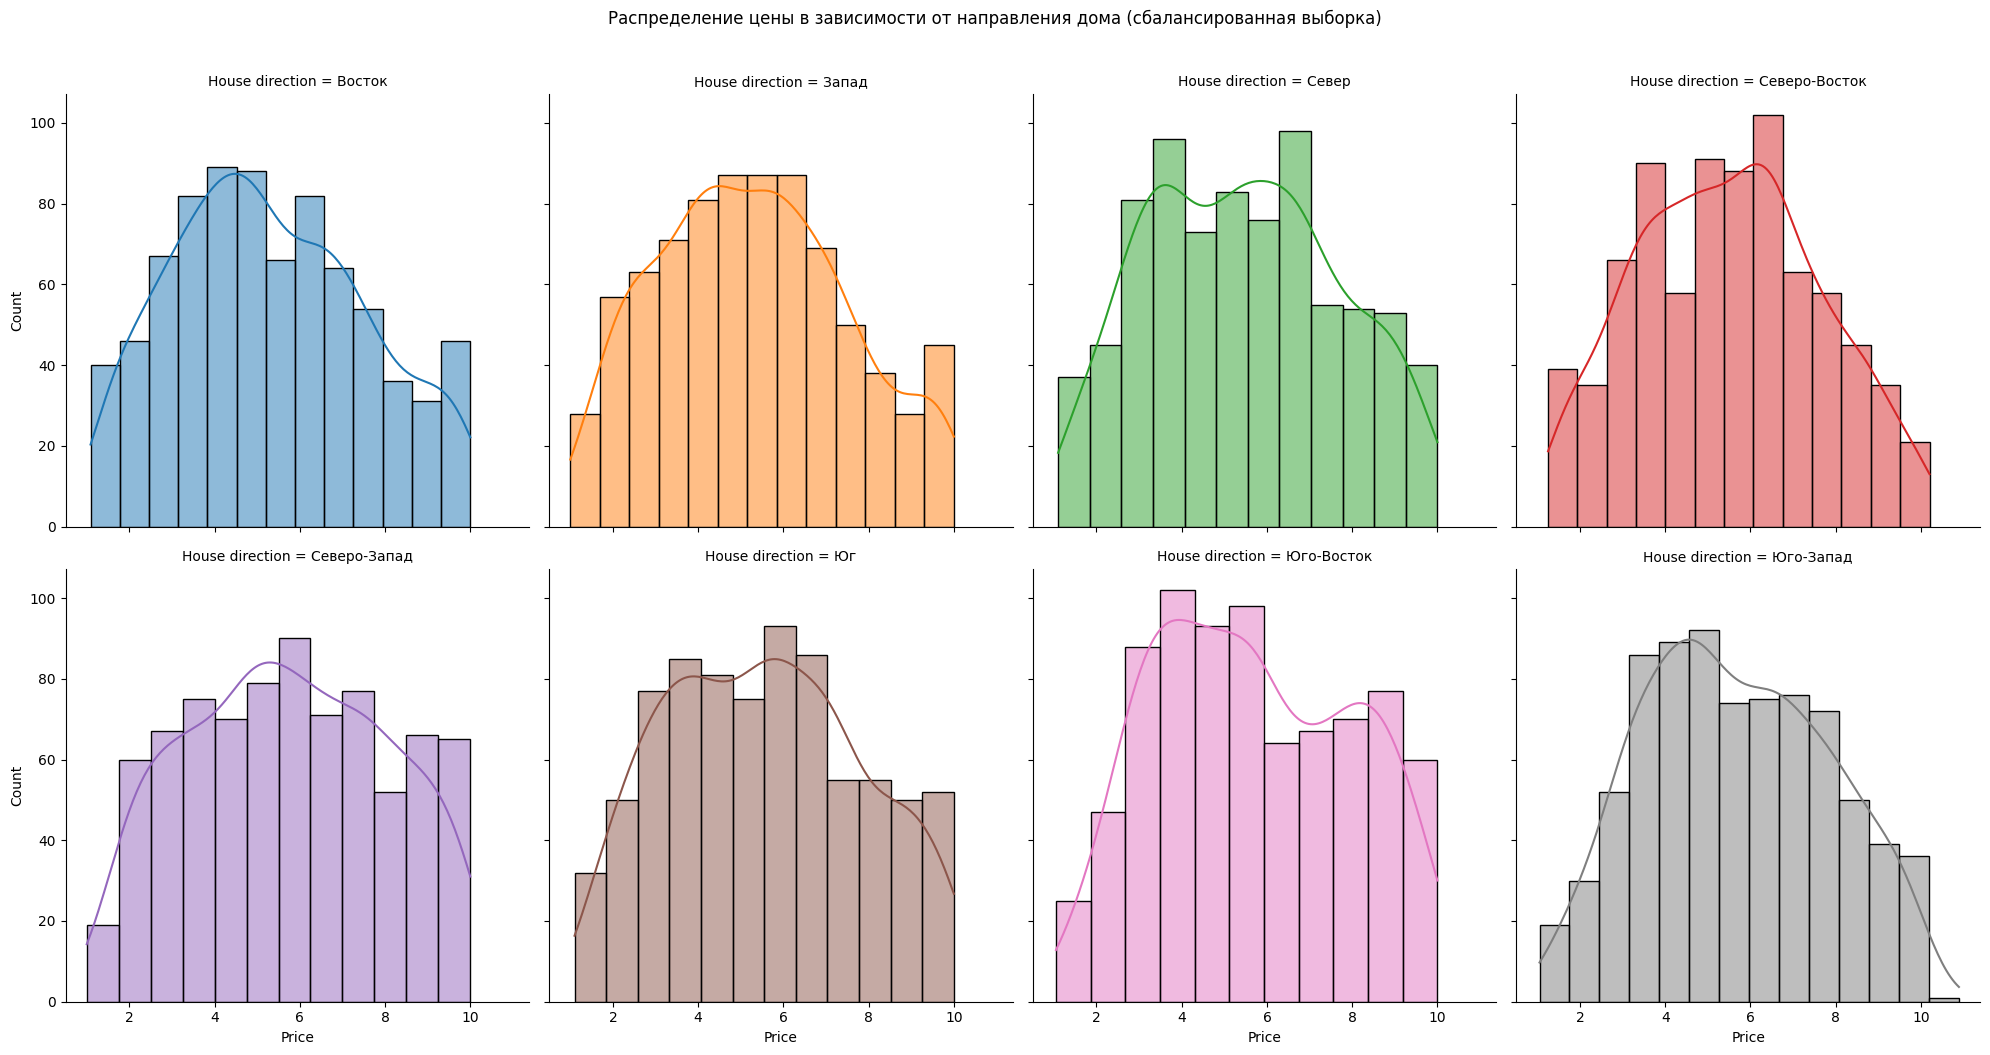

In [201]:
# @title Направление дома

# Создание словаря для замены значений
direction_mapping = {
    'Bắc': 'Север',
    'Nam': 'Юг',
    'Đông': 'Восток',
    'Tây': 'Запад',
    'Đông - Bắc': 'Северо-Восток',
    'Tây - Bắc': 'Северо-Запад',
    'Đông - Nam': 'Юго-Восток',
    'Tây - Nam': 'Юго-Запад'
}

# Замена значений в столбце House direction
df['House direction'] = df['House direction'].map(direction_mapping)

# Замена значений в столбце Balcony direction
df['Balcony direction'] = df['Balcony direction'].map(direction_mapping)

# Балансировка данных по признаку House direction
min_count = df['House direction'].value_counts().min()
sampled_df = df.groupby('House direction', group_keys=False).apply(lambda x: x.sample(min_count, random_state=42)).reset_index(drop=True)

# Создание FacetGrid для House direction
g = sns.FacetGrid(sampled_df, col='House direction', col_wrap=4, height=5, hue='House direction', palette='tab10')
g.map(sns.histplot, 'Price', kde=True)
g.fig.suptitle('Распределение цены в зависимости от направления дома (сбалансированная выборка)', y=1.05)

# Отображение графиков
plt.show()

<ipython-input-185-87979bb3cc23>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df2.groupby('Balcony direction').apply(lambda x: x.sample(min_count, random_state=42)).reset_index(drop=True)


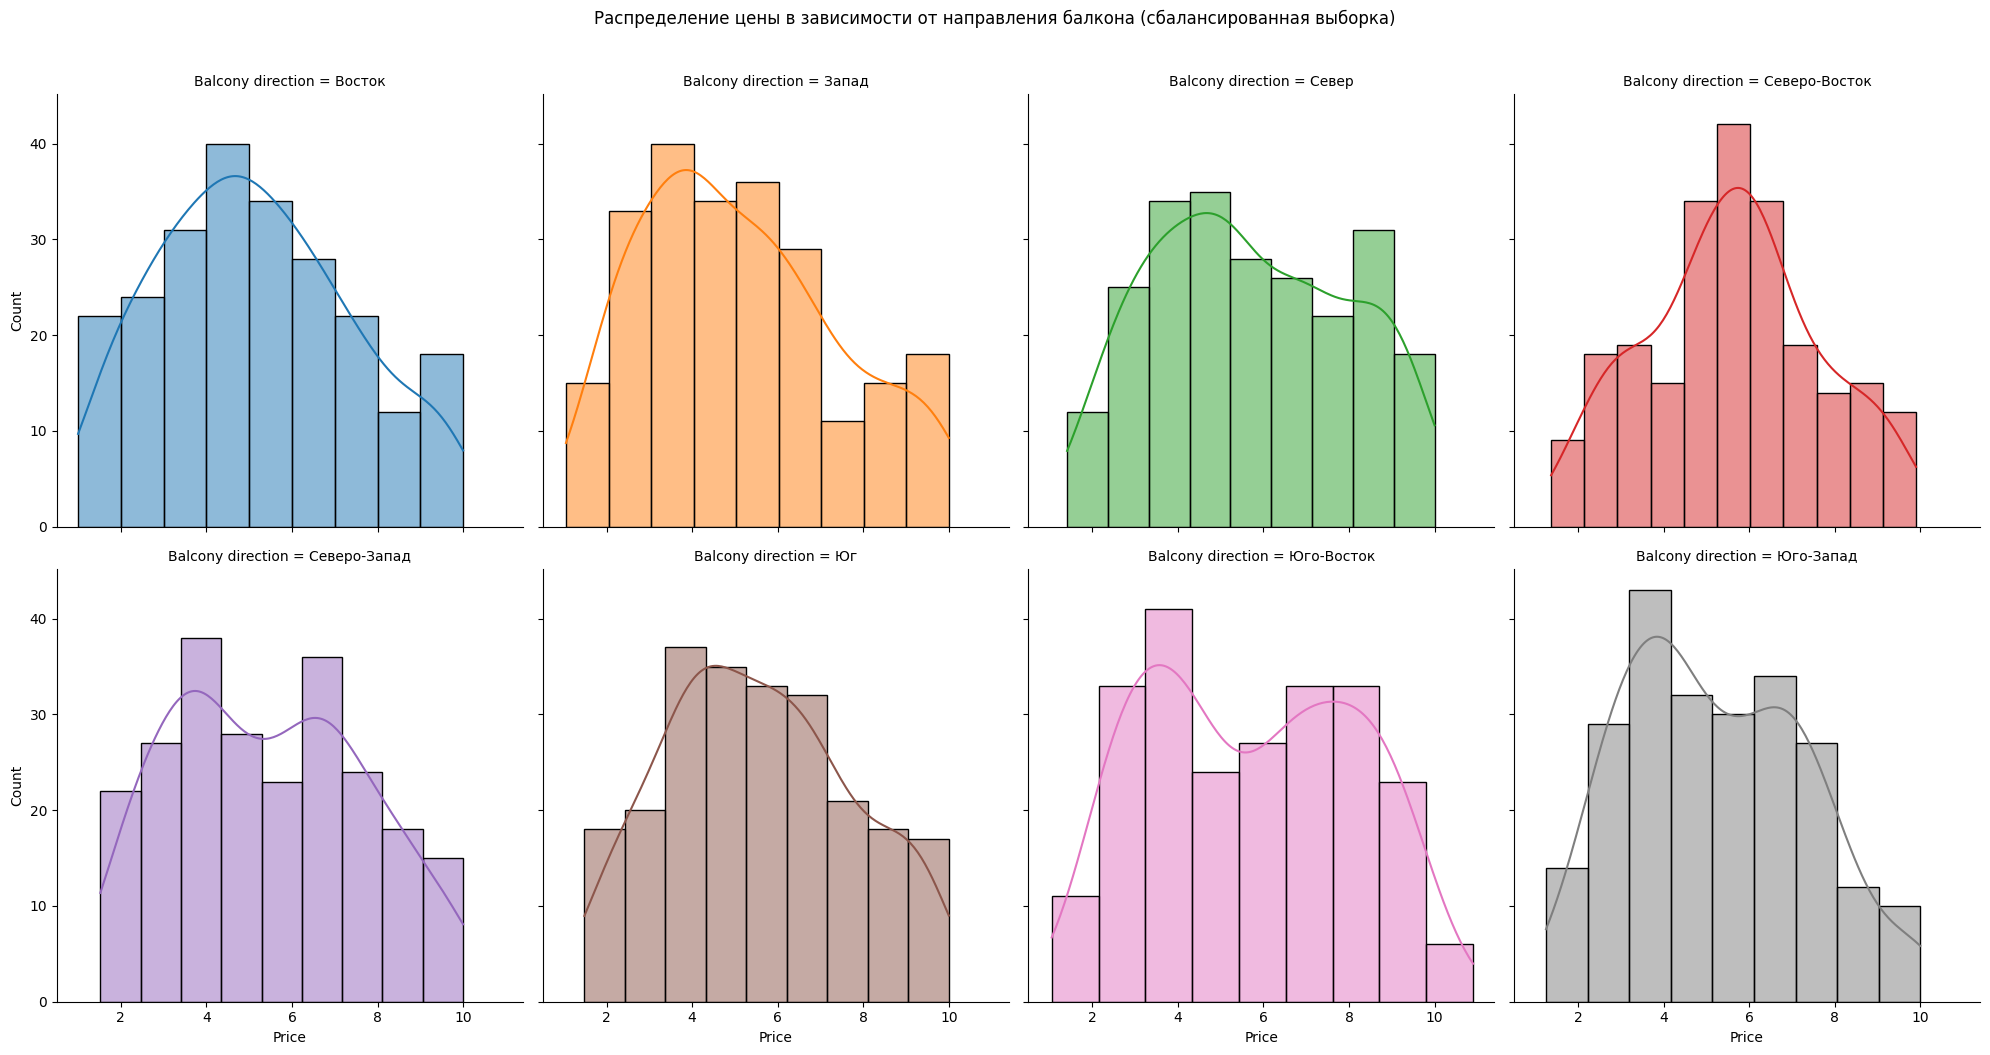

In [185]:
# @title Направление балкона
# Балансировка данных по признаку Balcony direction
min_count = df2['Balcony direction'].value_counts().min()
sampled_df = df2.groupby('Balcony direction').apply(lambda x: x.sample(min_count, random_state=42)).reset_index(drop=True)

# Создание FacetGrid для Balcony direction
g = sns.FacetGrid(sampled_df, col='Balcony direction', col_wrap=4, height=5, hue='Balcony direction', palette='tab10')
g.map(sns.histplot, 'Price', kde=True)
g.fig.suptitle('Распределение цены в зависимости от направления балкона (сбалансированная выборка)', y=1.05)

# Отображение графиков
plt.show()

In [202]:
# @title  Обработка категориальных признаков и заполнение пропусков
# Проверка наличия пропущенных значений
print(df.isnull().sum())

# Определение числовых и категориальных признаков
numeric_features = ['Area', 'Frontage', 'Access Road', 'Floors', 'Bedrooms', 'Bathrooms', 'Price']
categorical_features = ['Legal status', 'Furniture state', 'House direction', 'Balcony direction']

# Обработка категориальных признаков и заполнение пропусков
for feature in categorical_features:
    mode_value = df[feature].mode()[0]
    df.loc[:, feature] = df[feature].fillna(mode_value)

# Label Encoding для категориальных признаков
label_encoder = LabelEncoder()
label_encoded_df = df[categorical_features].apply(label_encoder.fit_transform)

# Замена категориальных признаков в исходном DataFrame на закодированные значения
df[categorical_features] = label_encoded_df

# Выбор только числовых признаков
df = df.select_dtypes(include=[np.number])

# Функция для заполнения пропущенных значений с использованием модели случайного леса
def fill_missing_values_with_model(df, target_column):
    # Копирование датафрейма
    df_filled = df.copy()

    # Итерация по каждому признаку
    for column in df_filled.columns:
        if df_filled[column].isnull().any():
            # Создание модели случайного леса
            model = RandomForestRegressor(random_state=42)

            # Выбор признаков для обучения модели
            features = df_filled.columns[df_filled.columns != column]

            # Разделение данных на обучающую и тестовую выборки
            X_train = df_filled[df_filled[column].notnull()][features]
            y_train = df_filled[df_filled[column].notnull()][column]
            X_test = df_filled[df_filled[column].isnull()][features]

            # Обучение модели
            model.fit(X_train, y_train)

            # Предсказание пропущенных значений
            y_pred = model.predict(X_test)

            # Заполнение пропущенных значений предсказанными значениями
            df_filled.loc[df_filled[column].isnull(), column] = y_pred

    return df_filled

# Заполнение пропущенных значений
df = fill_missing_values_with_model(df, 'Price')

Address                  0
Area                     0
Frontage             11564
Access Road          13297
House direction      21239
Balcony direction    24983
Floors                3603
Bedrooms              5162
Bathrooms             7074
Legal status          4506
Furniture state      14119
Price                    0
dtype: int64


In [ ]:
df

In [147]:
# @title  Нормализация данных
# Выбор числовых признаков для нормализации
numeric_features = ['Area', 'Frontage', 'Access Road', 'Floors', 'Bedrooms', 'Bathrooms', 'Price']
standard_scaler = StandardScaler()
df[numeric_features] = standard_scaler.fit_transform(df[numeric_features])

In [ ]:
df

In [148]:
# @title Обработка выбросов и разделение на обучающую и тестовую выборку
# Функция для выделения строк без выбросов
def remove_outliers(df, target_column):
    # Копирование датафрейма
    df_cleaned = df.copy()
    categorical_features = ['Legal status', 'Furniture state', 'House direction', 'Balcony direction']

    # Итерация по каждому признаку
    for column in df.columns:
        if ((column != target_column) and (column !=categorical_features[0])and (column !=categorical_features[1])and (column !=categorical_features[2])and (column !=categorical_features[3])):
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1

            # Определение границ выбросов
            lower_bound = Q1 - 1.5* IQR
            upper_bound = Q3 + 1.5* IQR

            # Удаление строк с выбросами
            df_cleaned = df_cleaned[(df_cleaned[column] >= lower_bound) & (df_cleaned[column] <= upper_bound)]

    return df_cleaned

# Выделение строк без выбросов
df_cleaned = remove_outliers(df, 'Price')

# Разделение данных на обучающую и тестовую выборки
X_cleaned = df_cleaned.drop('Price', axis=1)
y_cleaned = df_cleaned['Price']

X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned, test_size=0.25, random_state=42)

# Вывод результатов
print("\nРазмер очищенной обучающей выборки:", X_train.shape)
print("Размер очищенной тестовой выборки:", X_test.shape)



Размер очищенной обучающей выборки: (17754, 10)
Размер очищенной тестовой выборки: (5918, 10)


In [ ]:
df_cleaned

По сравнению с моделями Линейной регрессии, градиентного бустинга, случайного леса, нейронными сетями и XGBRegresson, модель CatBoost показывает наилучшие результаты.



In [154]:
# Определение сетки гиперпараметров для CatBoost
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'depth': [4, 6, 8, 10, 12],
    'l2_leaf_reg': [1, 3, 5, 7, 9, 11],
    'iterations': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    'early_stopping_rounds': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
}
# Создание и обучение модели CatBoost с использованием RandomizedSearchCV
cb_regressor = CatBoostRegressor(random_seed=42, verbose=0)
random_search = RandomizedSearchCV(cb_regressor, param_distributions=param_grid, n_iter=50, cv=5, scoring='neg_mean_squared_error', random_state=42)
random_search.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

# Выбор оптимального значения гиперпараметра
best_params = random_search.best_params_
print(f"\nОптимальные значения гиперпараметров: {best_params}")

# Создание и обучение модели CatBoost с оптимальными значениями гиперпараметров
cb_regressor_best = CatBoostRegressor(**best_params, random_seed=42, verbose=100)
cb_regressor_best.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

# Предсказание на тестовой выборке
y_test_pred = cb_regressor_best.predict(X_test)

# Оценка модели на тестовой выборке
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# Вывод результатов

print("\nПредсказанные значения на тестовой выборке:")
print(y_test_pred)
print("\nСреднеквадратичная ошибка (MSE) на тестовой выборке:", mse_test)
print("Коэффициент детерминации (R^2) на тестовой выборке:", r2_test)

# Предсказание на обучающей выборке
y_train_pred = cb_regressor_best.predict(X_train)

# Оценка модели на обучающей выборке
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

# Вывод результатов на обучающей выборке
print("\nПредсказанные значения на обучающей выборке:")
print(y_train_pred)
print("\nСреднеквадратичная ошибка (MSE) на обучающей выборке:", mse_train)
print("Коэффициент детерминации (R^2) на обучающей выборке:", r2_train)


Оптимальные значения гиперпараметров: {'learning_rate': 0.05, 'l2_leaf_reg': 11, 'iterations': 1000, 'early_stopping_rounds': 70, 'depth': 10}
0:	learn: 0.9564679	test: 0.9545732	best: 0.9545732 (0)	total: 23.2ms	remaining: 23.2s
100:	learn: 0.7129052	test: 0.7424231	best: 0.7424231 (100)	total: 3.37s	remaining: 30s
200:	learn: 0.6814188	test: 0.7296390	best: 0.7296390 (200)	total: 6.41s	remaining: 25.5s
300:	learn: 0.6621349	test: 0.7240158	best: 0.7240158 (300)	total: 8.65s	remaining: 20.1s
400:	learn: 0.6432673	test: 0.7187944	best: 0.7187944 (400)	total: 10.9s	remaining: 16.3s
500:	learn: 0.6270288	test: 0.7159327	best: 0.7159239 (499)	total: 13.2s	remaining: 13.1s
600:	learn: 0.6122323	test: 0.7132858	best: 0.7132217 (597)	total: 16.1s	remaining: 10.7s
700:	learn: 0.5983161	test: 0.7111800	best: 0.7111800 (700)	total: 19.6s	remaining: 8.37s
800:	learn: 0.5852722	test: 0.7095369	best: 0.7095369 (800)	total: 21.9s	remaining: 5.43s
900:	learn: 0.5739148	test: 0.7083700	best: 0.70828

1. Анализ результатов:

Тестовая выборка:

MSE: 0.5002

R^2: 0.4676

Обучающая выборка:

MSE: 0.3168

R^2: 0.6647

2. Интерпретация результатов:
1) Тестовая выборка:

MSE (Среднеквадратичная ошибка): 0.5002

Интерпретация: Среднеквадратичная ошибка на тестовой выборке составляет 0.5002. Это означает, что в среднем предсказанные значения отклоняются от фактических значений на 0.5002 единиц.

R^2 (Коэффициент детерминации): 0.4676

Интерпретация: Коэффициент детерминации на тестовой выборке составляет 0.4676. Это означает, что модель объясняет 46.76% дисперсии целевой переменной. Значение R^2 близко к 0.5, что указывает на среднюю точность модели.

2) Обучающая выборка:

MSE (Среднеквадратичная ошибка): 0.3168

Интерпретация: Среднеквадратичная ошибка на обучающей выборке составляет 0.3168. Это означает, что в среднем предсказанные значения отклоняются от фактических значений на 0.3168 единиц.

R^2 (Коэффициент детерминации): 0.6647

Интерпретация: Коэффициент детерминации на обучающей выборке составляет 0.6647. Это означает, что модель объясняет 66.47% дисперсии целевой переменной. Значение R^2 близко к 0.7, что указывает на хорошую точность модели на обучающей выборке.

3. Выводы:
Точность модели: Модель CatBoost показала среднюю точность на тестовой выборке (R^2 = 0.4676) и хорошую точность на обучающей выборке (R^2 = 0.6647). Это указывает на возможное переобучение модели, так как результаты на обучающей выборке значительно лучше, чем на тестовой.

Переобучение: Переобучение может быть вызвано недостаточным качеством данных, малым объемом данных или недостаточной информативностью признаков.

Оптимальные гиперпараметры: Модель была обучена с оптимальными гиперпараметрами, что улучшило её точность, но не решило проблему переобучения.